# PPO
---

### 1. Import the Necessary Packages

In [16]:
from model.ppo_3 import PPO
from env.wrappers import LunarContinuous, LunarLanderWithUnknownWind,LunarLanderWithKnownWind
from utils.logger import WandbSummaryWritter
import torch

### 2. Instantiate the Model

Setup the hyperparameters in the code cell below.

In [2]:
# hyperparameters = {
#     'timesteps_per_batch': 1024 ,                # Number of timesteps to run per batch
#     'max_timesteps_per_episode': 1200,           # Max number of timesteps per episode
#     'n_updates_per_iteration': 5,                # Number of times to update actor/critic per iteration
#     'lr': 2.5e-4 ,                                # Learning rate of actor optimizer
#     'gamma': 0.95,                               # Discount factor to be applied when calculating Rewards-To-Go
# }
# hyperparameters = {'gamma': 0.999, 'lr_gamma': 0.995,
#                    'max_timesteps_per_episode': 1200,'lr': 0.005 }

hyperparameters = {}

misc_hyperparameters = {
    'env': LunarLanderWithKnownWind
}

Initialise wandb session in the code cell below.

In [3]:
LOG = False
if LOG:
    logger = WandbSummaryWritter(project='lunar', config =misc_hyperparameters['env']().load_hyperparameters())
else:
    logger=None

Initialise the model fo the desired timestamps. Alternatively can specify a checkpoint to continue training.

In [20]:
checkpoint = 'wandb/run-20250110_180810-fl2v6ixe/files'
LOAD_MODEL = True

ppo = PPO(logger, **hyperparameters, **misc_hyperparameters)

if LOAD_MODEL:
    ppo.policy.load_state_dict(torch.load(checkpoint + "/base_model.pth"))
    ppo.adpt_module.load_state_dict(torch.load(checkpoint + "/adp_model.pth"))

RuntimeError: Error(s) in loading state_dict for ActorCriticWithEncoder:
	size mismatch for encoder.model.0.weight: copying a param with shape torch.Size([64, 8]) from checkpoint, the shape in current model is torch.Size([64, 9]).
	size mismatch for actor.model.0.weight: copying a param with shape torch.Size([64, 9]) from checkpoint, the shape in current model is torch.Size([64, 10]).
	size mismatch for critic.model.0.weight: copying a param with shape torch.Size([64, 9]) from checkpoint, the shape in current model is torch.Size([64, 10]).

### 3. Train the Model

Train model for specified amount of timestamps.

In [5]:
# ppo.train()


-------------------- Iteration #1 --------------------
Average Episodic Return: -13.26
Average Actor Loss: -0.21544
Average Critic Loss: 74.66090429746188
Average KL Divergence: 0.0
Iteration took: 11.03 secs, of which rollout took 10.4 secs and gradient updates took 0.63 secs
Current actor learning rate: 0.005
Current critic learning rate: 0.005
------------------------------------------------------


-------------------- Iteration #2 --------------------
Average Episodic Return: 94.94
Average Actor Loss: -0.21509
Average Critic Loss: 58.902500578073365
Average KL Divergence: 0.0
Iteration took: 9.66 secs, of which rollout took 8.97 secs and gradient updates took 0.69 secs
Current actor learning rate: 0.003333333333333334
Current critic learning rate: 0.003333333333333334
------------------------------------------------------


-------------------- Iteration #1 --------------------
Average adp Loss: 0.03845
Iteration took: 7.76 secs, of which rollout took 7.35 secs and gradient updat

### 4. Evaluate the Model

Run multiple episodes from pretrained model.

In [6]:
# ppo.validate(val_iter=30)
ppo.device = 'cpu'
import numpy as np
# val_rews, val_dur = ppo.validate(10, False, True, False)
# ppo.test()

wind_vals, base_z, adpt_z = ppo.validate_encoders_single_rollout()

[-13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874, -13.92874

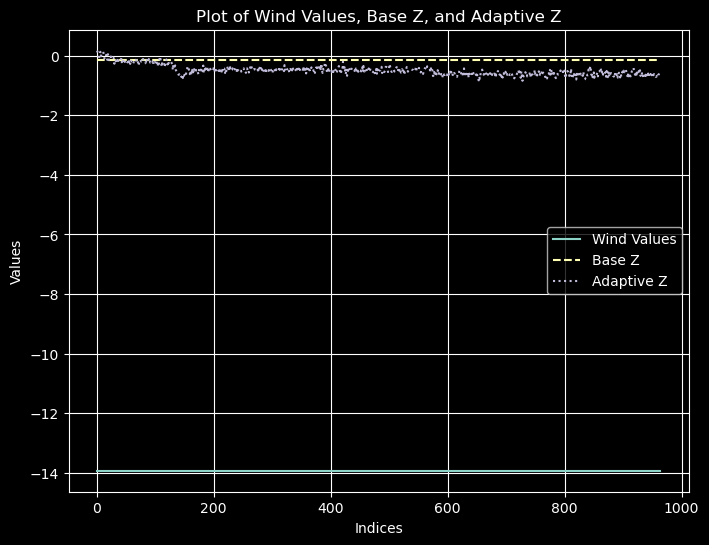

In [ ]:
import matplotlib.pyplot as plt
indices = range(len(wind_vals))

plt.figure(figsize=(8, 6))
plt.plot(indices, wind_vals, label="Wind Values")
plt.plot(indices, base_z, label="Base Z", linestyle='--')
plt.plot(indices, adpt_z, label="Adaptive Z", linestyle=':')

plt.xlabel("Indices")
plt.ylabel("Values")
plt.title("Plot of Wind Values, Base Z, and Adaptive Z")
plt.legend()
plt.grid(True)

plt.show()